# Images and Filters

This notebook intends to show you the differences between the original and filtered images that can be computed to extract additional radiomic features (high-order texture features).

In [1]:
#@title Install required libraries
# command to install a library is: !pip install <library_name> 
# we may choose a specific version by using !pip install <library_name>==<version>
# !pip install SimpleITK==2.0.0
!pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest
!pip install itkwidgets
!pip install PyWavelets

Looking in links: https://github.com/SimpleITK/SimpleITK/releases/tag/latest
     |████████████████████████████████| 48.5MB 92kB/s 
     |████████████████████████████████| 3.4MB 8.6MB/s 
     |████████████████████████████████| 50.1MB 75kB/s 
     |████████████████████████████████| 112kB 59.1MB/s 
     |████████████████████████████████| 276kB 58.1MB/s 
     |████████████████████████████████| 563kB 34.7MB/s 
     |████████████████████████████████| 2.2MB 51.5MB/s 
     |████████████████████████████████| 68.0MB 135kB/s 
     |████████████████████████████████| 1.6MB 54.2MB/s 
     |████████████████████████████████| 36.3MB 123kB/s 
ERROR: itk-meshtopolydata 0.6.4 has requirement itk-core>=5.2rc03, but you'll have itk-core 5.1.2 which is incompatible.


In [2]:
#@title Download example data
!wget --max-redirect=20 -O prostate_example.nii.gz https://www.dropbox.com/s/xypjy4x5do9qtw8/prostate_example.nii.gz

--2021-03-18 10:44:51--  https://www.dropbox.com/s/xypjy4x5do9qtw8/prostate_example.nii.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xypjy4x5do9qtw8/prostate_example.nii.gz [following]
--2021-03-18 10:44:51--  https://www.dropbox.com/s/raw/xypjy4x5do9qtw8/prostate_example.nii.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc75f348a69361b01e2d28cf50c9.dl.dropboxusercontent.com/cd/0/inline/BK6phXQd_71VdDQol5FtZk242maM1k7WUsDDF3ITn5JDMKGGIM_Mp-nflaRqtdUcoBgucJ-ONOQVOPNdiQ-g2MNhjEKyImUKlZ_M2TE7JA9MSc4LdH4HIp8Bth768HbMGHYyuqEBgHPWh3iY0RWM_77B/file# [following]
--2021-03-18 10:44:51--  https://uc75f348a69361b01e2d28cf50c9.dl.dropboxusercontent.com/cd/0/inline/BK6phXQd_71VdDQol5FtZk242maM1k7WUsDDF3ITn5JDMKGGIM_Mp-nfl

In [3]:
#@title Import libraries
import SimpleITK as sitk
import matplotlib.pyplot as plt

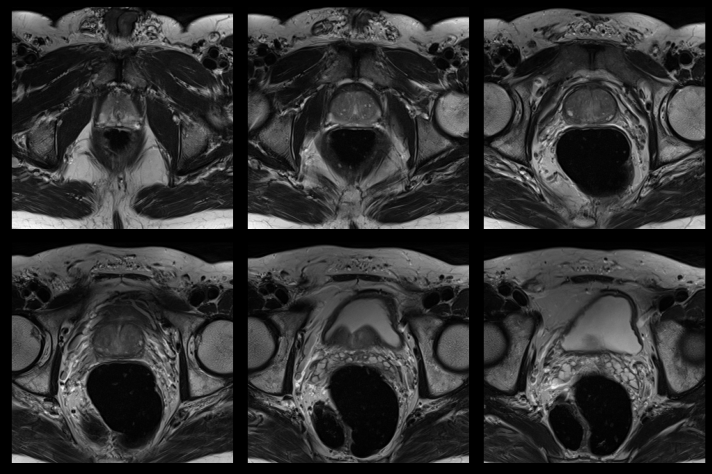

In [4]:
#@title Read example T2-weighted prostate MRI
#@markdown To read the image we will use SimpleITK and matplotlib.pyplot to display some slices of the prostate MRI T2-weighted scan.
# read prostate MRI image (3D volume) and assign it to the variable image
image = sitk.ReadImage('prostate_example.nii.gz')

# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
axes[1,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-15, w_pad=1)

In [5]:
#@title Create copy of image in float 64-bits (double precision)
#@markdown In order to not lose information we will transform the voxel type of our image into 64-bits floating point (double precision).
# cast image voxel bit depth to 64-bits
image_float64 = sitk.Cast(image,sitk.sitkFloat64)

In [6]:
#@markdown Create examples of:

#@markdown * Laplacian of Gaussian with sigma of 1 mm
#@markdown * Laplacian of Gaussian with sigma of 5 mm
#@markdown * Exponential
#@markdown * Logarithm
#@markdown * Square
#@markdown * Square-Root
#@markdown * Wavelet decompositions
image_log_sigma_1 = sitk.LaplacianRecursiveGaussian(image_float64, sigma=1)
image_log_sigma_5 = sitk.LaplacianRecursiveGaussian(image_float64, sigma=5)
image_exponential = sitk.Exp(sitk.Normalize(image_float64))
image_logartihm = sitk.Log(image_float64)
image_square = sitk.Square(image_float64)
image_sqrt = sitk.Sqrt(image_float64)

import pywt
import pywt.data


# Load image
original = sitk.GetArrayFromImage(image_float64)[8,:,:]

# Wavelet transform of image, and plot approximation and details
titles = ['Wv-LL: Approximation', 'Wv-LH: Horizontal detail',
          'Wv-HL: Vertical detail', 'Wv-HH: Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2

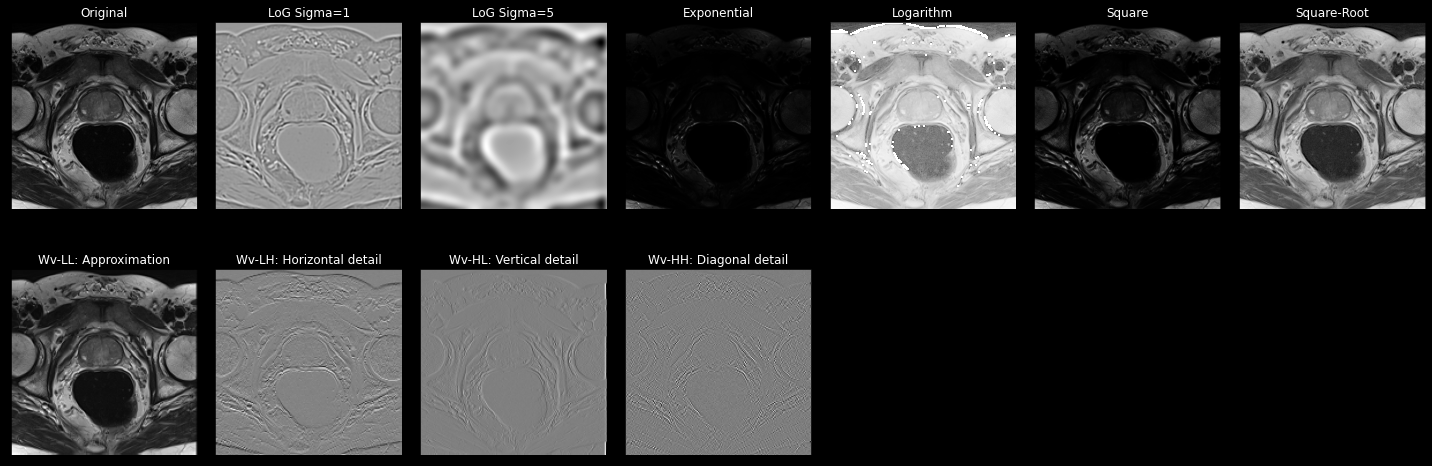

In [7]:
#@markdown And now lets visualize them and compare them side by side with the original image.
# select a couple of slices to display
fig, axes = plt.subplots (nrows = 2, ncols = 7, figsize = (20, 20))
rect = fig.patch
rect.set_facecolor('black')

axes[0,0].imshow(sitk.GetArrayFromImage(image_float64)[8,:,:], cmap='gray')
axes[0,1].imshow(sitk.GetArrayFromImage(image_log_sigma_1)[8,:,:], cmap='gray')
axes[0,2].imshow(sitk.GetArrayFromImage(image_log_sigma_5)[8,:,:], cmap='gray')
axes[0,3].imshow(sitk.GetArrayFromImage(image_exponential)[8,:,:], cmap='gray')
axes[0,4].imshow(sitk.GetArrayFromImage(image_logartihm)[8,:,:], cmap='gray')
axes[0,5].imshow(sitk.GetArrayFromImage(image_square)[8,:,:], cmap='gray')
axes[0,6].imshow(sitk.GetArrayFromImage(image_sqrt)[8,:,:], cmap='gray')


axes[1,0].imshow(LL, cmap='gray')
axes[1,1].imshow(LH, cmap='gray')
axes[1,2].imshow(HL, cmap='gray')
axes[1,3].imshow(HH, cmap='gray')

axes[0,0].set_title('Original', color='w')
axes[0,1].set_title('LoG Sigma=1', color='w')
axes[0,2].set_title('LoG Sigma=5', color='w')
axes[0,3].set_title('Exponential', color='w')
axes[0,4].set_title('Logarithm', color='w')
axes[0,5].set_title('Square', color='w')
axes[0,6].set_title('Square-Root', color='w')
fig.delaxes(axes[1][4])
fig.delaxes(axes[1][5])
fig.delaxes(axes[1][6])

axes[1,0].set_title(titles[0], color='w')
axes[1,1].set_title(titles[1], color='w')
axes[1,2].set_title(titles[2], color='w')
axes[1,3].set_title(titles[3], color='w')

for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=-75, w_pad=1)